## Latest summary of objectives

- Develop an efficient solver.
- Develop a grid generator that satisfies some measures of symmetry, randomness, uniformity, etc.
- Analyze the number of solutions for various grids.
- Create generators that produce grids with different distributions of solutions.

## 2025-12-03: Intro

I saw my kid playing <a href="https://youtube.com/watch?v=VAdmJ525lXY">Stitch.</a>, so naturally I wanted to write a solver for it. If I understand correctly, the game is based on <a href="https://en.wikipedia.org/wiki/Shikaku">Shikaku</a>:

> Shikaku is played on a rectangular grid. Some of the squares in the grid are numbered. The objective is to divide the grid into rectangular $\dots$ pieces such that each piece contains exactly one number, and that number represents the area of the rectangle.

I will try to consistently use terms as follows:
- **Grid** is used as described above and refers to the puzzle as presented to the player. It is composed of squares and contains numbers but not rectangles.
- **Square** refers to an individual cell in the grid.
- **Rectangle** refers to a solid rectangle formed by one or more squares.
- **Number** refers to one of the numbers in the grid. It resides in a particular square and in a solution is associated with a particular rectangle.

### Thoughts about a solver

Which of the following will be more efficient?

- choosing as the next step in the search a particular square containing a number, or a particular square regardless of whether it contains a number, in either case finding all possible rectangles containing that square
- if choosing only squares with numbers — starting from larger numbers, or smaller numbers, or prime numbers, or numbers with the most factors
- choosing a next step adjacent to or distant from the previous step
- starting from the inside or the outside
- breadth-first search or depth-first search

For example, would doing all four corners first be more efficient? Walking the perimeter? Starting from the largest numbers?

Also, what should I compute in advance?

- Which numbers' rectangle could overlap with a given square?
- Should I skip right to which rectangles could overlap with a given square?
- Is it practical to cache results for a given partial solution?
- Are there arrangements of numbers that can be efficiently reduced into their possible combinations of rectangles? (My gut says no, not efficiently.)

How large of a grid am I willing to consider? How high of numbers will I allow?

And I quickly realized that generating sample grids is not at all trivial.

### Thoughts about grid generation

I have the sense that attempting to generate a "random" grid is <a href="https://www.youtube.com/watch?v=mZBwsm6B280">almost a meaningless statement</a>.

Let's look at how many possible 2 $\times$ 2 grids there are. For any given collection of rectanges, each rectangle's number $n$ could have been be placed in any of the $n$ squares within the rectangle. This means the quantity of grids produced by any given collection of rectangles is equal to the product of the rectangles' areas, or numbers, less any duplication that may occur from different collections of rectangles producing the same grid. These are the possible combinations of rectangle areas and how many distinct ways they can occur:

- (4,) — 1 distinct partition
- (2, 2) — 2 distinct partitions, vertically or horizontally
- (2, 1, 1) — 4 distinct partitions, as the 2 can be vertical or horizontal and in the first or second row/column
- (1, 1, 1, 1) — 1 distinct partition

These suggest 21 total grids from these 8 distinct partitions, but only 19 of the grids are distinct. In the (2, 2) case, the numbers can be on a diagonal whether the rectangles are vertical or horizontal, so instead of $(2 \times 2) \times 2 = 8$ there are only 6 distinct grids from this case.

Still, that's 19 distinct grids from 8 distinct partitions, and most of these partitions have a significant number of rectangles of size 1. (My kid says size 1 is allowed, but I haven't seen this in the examples I've found online.) I imagine that grids-to-partitions ratio may grow as the size of the grid grows. And even if it doesn't, <a href="https://oeis.org/A333476">OEIS A333476</a> indicates that there are over 84 million distinct partitions for a $5 \times 5$ rectangle.

Getting back to grid generation — what would a "random $5 \times 5$ grid" mean? Would it mean generating all 84 million distinct partitions, and all their however-many distinct grids, and then randomly selecting one? That's not a practical approach. It's also probably misguided. To the extent that there is some real "population" of grids that I would try to make my solver efficient at solving, those grids would have been created by some algorithm, and I'd effectively be trying to figure out what that algorithm might be.

Perhaps as I go about testing my own algorithms for grid generation, I can evaluate them with statistics. It's not clear to me whether on average I should expect the locations of numbers to be uniformly distributed throughout the grid, but I would expect numbers to be equally likely between symmetrical positions. For example, there shouldn't be a bias toward the upper-left.

Also, I may be able to find enough examples of puzzles intended for humans to solve that I can establish a preference for the relative frequency of different numbers. On average there should probably be more 3s than 9s, but how much more? Should there be more 7s or 8s?

I'm also interested in how many solutions a grid has. One of my favorite puzzle games, <a href="https://en.wikipedia.org/wiki/Flow_Free">Flow Free</a>, seems to limit its puzzles to those with a unique solution. I wonder whether, for example, the numbers in a grid, or their positions, may be correlated with how many solutions the grid has. And then by tweaking the generation algorithm, I would be more likely to create grids with very few or very many solutions.

### Objectives

- Write a solver. Make it quantifiably better.
- Write a grid generator. Make it statistically defensible.
- Analyze the number of solutions for various grids. Tweak the generator as desired without losing its statistical defensibility.

## 2025-12-04: Bit masking and preprocessing

I've decided I will only consider rectangles of size 2 or greater, partly because this seems to be the convention for published puzzles. Size 1 rectangles are equivalent to holes in the grid (or free spaces). Handling non-rectangular grids or grids with holes feels like a straightforward enhancement of what I'll eventually build, but I'm more interested in fine-tuning the algorithm and analyzing the statistics, so I don't know that I'll get to it. But if I do, it's effectively the same as a rectangular puzzle with the number 1 everywhere within the bounding box but outside the grid.

Now a big part of making the eventual algorithm efficient will be checking whether two rectangles overlap, or whether a rectangle contains a particular square. I'll be using Python, but any use of lists or tuples or even NumPy arrays will be very slow. Bitwise operations in Python are very fast, so a more efficient approach is to use a bit mask. Any rectangle or collection of rectangles overlaps a collection of squares. We can represent whether it overlaps any given square with just one bit: 1 for yes, 0 for no. If all squares in the grid are always considered in the same order, those bits can be interpreted as a binary number. If there is any bit that is set to 1 in both of the binary numbers representing two objects, the objects both contain the square associated with that bit and therefore the two objects overlap. For example:

```
for candidate in candidates:
    if candidate & collection:
        continue
    do_stuff()
```

This would skip any candidate that overlaps with the existing collection.

I also think it will turn out to be efficient to compute in advance the bitmask for each possible rectangle for a given grid. For each number $n$ in the grid:

- Compute all pairs of factors $(x,y)$ such that $x \times y = n$. For $n = 6$ these pairs would be $(1,6)$, $(2,3)$, $(3,2)$, $(6,1)$.
- For each pair of factors, consider each rectangle of that shape that overlaps with the sqaure containing the number.
- Any rectangle that overlaps another number is not possible.
- Any rectangle that extends beyond the grid is not possible.
- Any remaining rectangle is possible.

## 2025-12-05: Initial thoughts on representing the grid

Here is the <a href="https://en.wikipedia.org/wiki/Shikaku#/media/File:Shikaku_start.png">sample puzzle</a> on the Wikipedia page at the time I'm writing this:
```
+--+--+--+--+--+--+--+--+--+--+--+
|  | 4|  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 2| 4|  |  | 3|  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |16|  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 6| 5| 2| 4|  |  | 4|  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  | 2| 5|  |  | 2|  | 7|
+--+--+--+--+--+--+--+--+--+--+--+
|  |  | 2|  |  | 2| 4|  | 2|  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |16|  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |12|  | 6|  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 2|  |  |  |  |  |  |  |  | 9|  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
```
It would be nice if the printed representation of the grid/puzzle could be read back in as that puzzle. I might add that at some point, but for now I'll parse it down to something simpler to work with.

In [1]:
sample_grid_repr = """
+--+--+--+--+--+--+--+--+--+--+--+
|  | 4|  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 2| 4|  |  | 3|  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |16|  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 6| 5| 2| 4|  |  | 4|  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  | 2| 5|  |  | 2|  | 7|
+--+--+--+--+--+--+--+--+--+--+--+
|  |  | 2|  |  | 2| 4|  | 2|  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |16|  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |12|  | 6|  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 2|  |  |  |  |  |  |  |  | 9|  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
"""

sample_grid_cleaned = '\n'.join(
    line[1:-1].replace('|', ',').replace(' ', '')
    for line in sample_grid_repr.strip().split('\n')[1::2])

print(sample_grid_cleaned)

,4,,,,,,,,,
2,4,,,3,,,,,,
,,,,,,,16,,,
6,5,2,4,,,4,,,,
,,,,2,5,,,2,,7
,,2,,,2,4,,2,,
,,,,16,,,,,,
,,,,,,,,,,
,,,,12,,6,,,,
2,,,,,,,,,9,
,,,,,,,,,,


To make it straightforward to generate the bit mask for each rectangle, I think I'll want to use NumPy arrays. For example, for a grid with `r` rows and `c` columns:

```
import numpy as np
bitmask = np.array([2 ** i for i in range(r * c)]).reshape((r, c))
```

I'll want to compute the possible rectangle sizes for a given number:

```
from sympy import divisors
factors = divisors(number)
shapes = list(zip(factors, factors[::-1]))
```

TO DO:

- iterate all possible positions/offsets of the rectangle of each shape for each number
- filter out any that extend beyond the grid or overlap any other number
- add each remaining rectangle to any appropriate maps

I'll want at least a couple of maps (dicts in Python):

- squares with numbers -> that square's number
- squares -> list of possible rectangles containing that square

## 2025-12-06: A couple of thoughts

A solvable puzzle will remain solvable if a number is moved to any other square in its rectangle. This means a solvable collection of rectangles can have a ridiculously large number of grid variants. How to choose among them? Randomly sample, test for number of solutions, compute statistics, ...?

In [2]:
import math

variants = math.prod(int(n) for n in sample_grid_cleaned.replace(',', ' ').split())
print(f"Sample grid has {variants:,} variants.")

Sample grid has 136,982,613,196,800 variants.


A grid generator where number 1 is not allowed can reach a dead end. I may want to track how many dead ends are reached before a solvable grid is returned.

## 2026-01-01: First solver

Picking this back up after <a href="https://adventofcode.com/2025">Advent of Code</a> and the holidays.

While thinking about a solver over the past few days, I thought in terms of additional for-loops and not NumPy arrays. So I wrote everything using for-loops and the standard library.

First is a helper function for identifying all factors for a given number. I could make this more efficient by precomputing all pairs of factors and accessing them from a list by index. Or at least using `functools.cache()`. I'll optimize later.

In [3]:
def factors(n):
    return [i for i in range(1, n + 1) if n % i == 0]

assert factors(12) == [1, 2, 3, 4, 6, 12]
assert factors(13) == [1, 13]

Next is computing the bitmask, relative to the grid, for all squares in a rectangle. Zero is returned if the rectangle doesn't stay within the grid. I moved this inside the class I decided to create, but I left this version here because I tested a handful of cases. I'm trying to show some of the thought process here...

In [4]:
def bitmask_rectangle(H, W, r, c, h, w):
    if r < 0 or c < 0 or r + h > H or c + w > W:
        return 0
    result = 0
    for r0 in range(r, r + h):
        for c0 in range(c, c + w):
            result += 2 ** (r0 * W + c0)
    return result

assert bitmask_rectangle(3, 4, -1, 1, 1, 2) == 0
assert bitmask_rectangle(3, 4, 1, -1, 1, 2) == 0
assert bitmask_rectangle(3, 4, 1, 1, 1, 2) == 96
assert bitmask_rectangle(3, 4, 1, 1, 3, 1) == 0
assert bitmask_rectangle(3, 4, 1, 1, 1, 4) == 0
assert bitmask_rectangle(3, 4, 0, 0, 2, 3) == 119

...although with the class below, the thought process was too messy to try to tell as a story. I knocked out this class while watching both *Wicked* movies for the first time. There were a number of false starts and dead ends.

For the depth-first search I decided to choose the next rectangle based on an empty square rather than an unused number, because it saved me the step of explicitly tracking which numbers have been used. (Although I did leave `Rs` in there for future optimization tests.)

Currently there's no validation that the input is rectangular.

In [5]:
from collections import defaultdict
from math import log2

class Grid:
    def __init__(self, s):
        self.s = s
        lines = s.strip().split('\n')
        self.H = len(lines)
        self.W = len(lines[0].split(','))
        self.MAX = 2 ** (self.H * self.W) - 1

        self.Ns = {}  # Number for a given Square
        for r, row in enumerate(lines):
            for c, char in enumerate(row.split(',')):
                if char:
                    self.Ns[2 ** (r * self.W + c)] = int(char)  # convert row and column to bit

        self.Rs = defaultdict(list)  # list of possible Rectangles containing a given Number
        self.Qs = defaultdict(list)  # list of possible Rectangles containing a given Square
        for this_p, n in self.Ns.items():
            r, c = divmod(int(log2(this_p)), self.W)  # convert bit back to row and column
            other_ps = sum(self.Ns) - this_p
            F = factors(n)
            for h, w in zip(F, reversed(F)):  # all possible Rectangle shapes
                for dh in range(h):           # all possible horizontal offsets
                    for dw in range(w):       # all possible vertical offsets
                        rectangle = self.bitmask_rectangle(r - dh, c - dw, h, w)
                        if rectangle and not rectangle & other_ps:  # has set bits and doesn't overlap any other Number
                            self.Rs[this_p].append(rectangle)
                            for r0 in range(r - dh, r - dh + h):
                                for c0 in range(c - dw, c - dw + w):
                                    self.Qs[2 ** (r0 * self.W + c0)].append(rectangle)

    def bitmask_rectangle(self, r, c, h, w):
        if r < 0 or c < 0 or r + h > self.H or c + w > self.W:
            return 0
        result = 0
        for r0 in range(r, r + h):
            for c0 in range(c, c + w):
                result += 2 ** (r0 * self.W + c0)
        return result

    def dfs(self, rs: set):
        current = sum(rs)  # union of accumulated rectangles
        if current == self.MAX:
            yield rs
        # continue from some empty square; for now, using lowest zero bit
        lowest_zero_bit = ~current & (current + 1)
        if lowest_zero_bit <= self.MAX:
            for rectangle in self.Qs[lowest_zero_bit]:
                if not rectangle & current:
                    next_rs = rs | {rectangle}
                    yield from self.dfs(next_rs)

    def solve(self):
        yield from self.dfs(set())

    def __repr__(self):
        output = []
        spacer_row = '+' + '--+' * self.W
        output.append(spacer_row)
        for line in self.s.strip().split('\n'):
            row = [f"{value:>2}" for value in line.split(',')]
            output.append('|' + '|'.join(row) + '|')
            output.append(spacer_row)
        return '\n'.join(output)

Testing it on the Wikipedia puzzle:

In [6]:
test_grid = Grid(sample_grid_cleaned)

In [7]:
test_solutions = [solution for solution in test_grid.solve()]

In [8]:
print(test_grid)
print(f"Number of solutions: {len(test_solutions)}")

+--+--+--+--+--+--+--+--+--+--+--+
|  | 4|  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 2| 4|  |  | 3|  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |16|  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 6| 5| 2| 4|  |  | 4|  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  | 2| 5|  |  | 2|  | 7|
+--+--+--+--+--+--+--+--+--+--+--+
|  |  | 2|  |  | 2| 4|  | 2|  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |16|  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |12|  | 6|  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 2|  |  |  |  |  |  |  |  | 9|  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
Number of solutions: 1


Well, I didn't necessarily expect there would be just a single solution. I hadn't tried to solve it by hand :)

A few reality checks. The possible rectangles for the 2 in the second row:

In [9]:
for n in test_grid.Rs[2 ** 11]:
    print(f"{bin(n)[2:]:>30}")

       10000000000100000000000
                  100000000001


The possible rectangles for the square in the upper-left corner:

In [10]:
for n in test_grid.Qs[2 ** 0]:
    print(f"{bin(n)[2:]:>30}")

                          1111
                  100000000001


The bitmasks for the rectangles in the solution:

In [11]:
test_solutions

[{15,
  4196352,
  25178112,
  67141648,
  550024380480,
  16500731414400,
  70403103916032,
  140806241402880,
  281612415664128,
  563224965611552,
  13510798882111488,
  432345564227567616,
  1729382256910270464,
  6920906727361609728,
  27670116110564327424,
  302379100949042559975424,
  154213304716685954745630720,
  309636199371819590004768768,
  1298708039933821021833372433907712,
  38961250482564925295353234760663040,
  124676001544207760945130351234121728,
  1163642681079272435487883278185136128,
  1329877349959700883100624741111693312}]

Before anything else, I tried a simple case where I knew there were multiple solutions:

In [12]:
s2 = """
2,
,2
"""

In [13]:
test_grid_2x2 = Grid(s2)
test_solutions_2x2 = [solution for solution in test_grid_2x2.solve()]

In [14]:
print(test_grid_2x2)
print(f"Number of solutions: {len(test_solutions_2x2)}")

+--+--+
| 2|  |
+--+--+
|  | 2|
+--+--+
Number of solutions: 2


In [15]:
test_solutions_2x2

[{3, 12}, {5, 10}]

I'd like to test more examples of decent size, particularly some where I know there are multiple solutions. But first, can I visualize the collection of rectangles?

In [16]:
import random
from string import ascii_letters, digits
from IPython.display import display, HTML

def visualize_ascii(grid, solution, seed=None):
    if seed is not None:
        random.seed(seed)
    chars = list(digits + ascii_letters)
    random.shuffle(chars)

    labels = [None for _ in range(grid.H * grid.W)]
    for i, r in enumerate(solution):
        bitstring = bin(r)[2:][::-1]
        for j, bit in enumerate(bitstring):
            if bit == '1':
                labels[j] = i
    
    i = 0
    n = 1
    lines = []
    for r in range(grid.H):
        line = []
        for c in range(grid.W):
            if n in grid.Ns:
                line.append(f"<b>{chars[labels[i]]}</b>")
            else:
                line.append(chars[labels[i]])
            i += 1
            n *= 2
        lines.append(''.join(line))
    full_output = '\n'.join(lines)
    html_string = f"<pre style='font-family: monospace; line-height: 1.1;'>{full_output}</pre>"
    display(HTML(html_string))

In [17]:
visualize_ascii(test_grid, test_solutions[0], seed='test_grid')

In [18]:
for i, solution in enumerate(test_solutions_2x2, start=1):
    visualize_ascii(test_grid_2x2, solution, seed='2x2')

## 2026-01-04: Randomizer for an existing puzzle

From continuing research, I've gathered that a proper shikaku puzzle should have a single solution, and not even require backtracking once the right break-in is found. That's fine, but what interests me here isn't just how to solve a particular type of puzzle but rather how to generate scenarios with certain statistical properties that lead to accurate predictions.

So, generating some scenarios, i.e. some puzzles. To implement a randomized generator, I might start from the topmost and then leftmost empty square and randomly (and probably *not* uniformly) choose the size and shape of rectangle with that square at its top-left. I would have to backtrack if I were left with no option other than a $1 \times 1$ square, although I feel like that would only happen on the bottom row. (How does one backtrack and try other options without repetition when selecting randomly?) I have a feeling that this approach would tend to produce "lopsided" puzzles, or perhaps would tend to produce exact covers (I may be misusing that term; the collection of rectangles) that are more likely or less likely to lead to puzzles with a larger number of solutions. I should definitely implement this to assess the statistical properties, once I have figured out how to measure them.

What I want to do tonight is write a randomizer that takes an existing collection of rectangles, randomly places each rectangle's number in any square of that rectangle, solves the resulting puzzle, and counts the solutions. At first I won't worry about the details of the solutions or even the puzzles, just the total counts.

In [19]:
from collections import Counter

def randomize_v1(grid, solution, N, seed=None):
    if seed is not None:
        random.seed(seed)
    numbers = []
    choices = []
    for x in solution:
        numbers.append(x.bit_count())
        bits = []
        while x:
            low_bit = x & -x
            bits.append(low_bit)
            x ^= low_bit
        choices.append(random.choices(bits, k=N))

    results = Counter()
    for choice in zip(*choices):
        clues = {}
        for i, bit in enumerate(choice):
            number = numbers[i]
            r, c = divmod(int(log2(bit)), grid.W)
            clues[(r, c)] = number
        rows = []
        for r in range(grid.H):
            row = []
            for c in range(grid.W):
                row.append(str(clues.get((r, c), '')))
            rows.append(','.join(row))
        grid = Grid('\n'.join(rows))
        count = sum(1 for _ in grid.solve())
        results[count] += 1
    return results

Fixed a bug in `Grid` where I hadn't properly computed `W`, I hadn't used `.split(',')` to properly determine the number of squares in the row.

For efficiency's sake it may be useful to change the `Grid` class to construct from a `dict` as well as from a string.

In [20]:
randomize_v1(test_grid_2x2, test_solutions_2x2[0], 100, seed='chocolate')

Counter({1: 54, 2: 46})

You were expecting this to be around 50%, right?

Now, for the Wikipedia example, I have no idea what to expect.

In [21]:
random_v1_100 = sorted(randomize_v1(test_grid, test_solutions[0], 100, seed='praline').items())
random_v1_100

[(1, 29), (2, 42), (3, 1), (4, 20), (6, 3), (7, 1), (8, 2), (12, 1), (28, 1)]

Okay, that's interesting. What does that distribution look like?

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

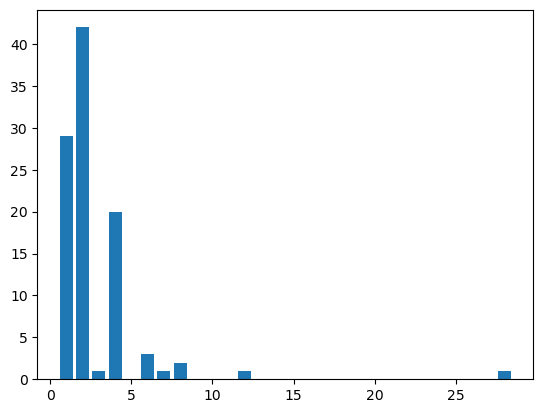

In [23]:
plt.bar(*zip(*random_v1_100));

The randomizer isn't particularly fast, but let's see what 1000 puzzles look like.

In [24]:
random_v1_1000 = sorted(randomize_v1(test_grid, test_solutions[0], 1000, seed='praline').items())
random_v1_1000

[(1, 226),
 (2, 439),
 (3, 19),
 (4, 225),
 (6, 28),
 (7, 3),
 (8, 23),
 (10, 6),
 (12, 18),
 (14, 3),
 (16, 4),
 (20, 1),
 (28, 4),
 (44, 1)]

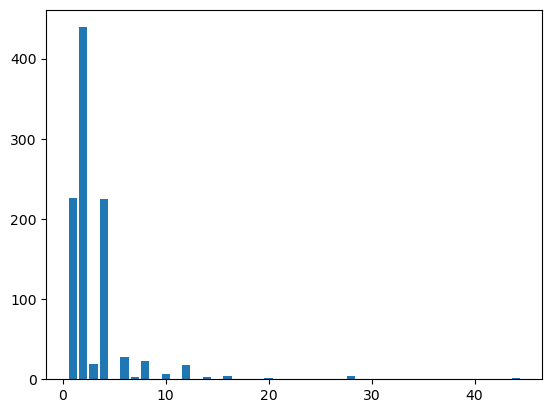

In [25]:
plt.bar(*zip(*random_v1_1000));

It appears that there is less than a 30% chance that a puzzle created by randomly positioning each clue/number within this collection of rectangles will have only this collection of rectangles as a unique solution.

That 2 is predominant makes me think there is some small area responsible, and looking back at the original Wikipedia puzzle, I imagine it is the 2s in the ninth column.

I'm a bit surprised that 44 appears but neither 11 nor 22 does. That could just be due to randomness. Curiously, 16 + 28 = 44, and I wonder whether if all possible randomizations were generated, would there be some rule for the counts, like would every count greater than one have to equal the sum of two (not necessarily distinct) smaller counts among the results? I could investigate this with smaller grids.

One last thought for tonight — I'm curious how sensitive the puzzle is to being perturbed rather than fully randomized. If only one or two or three numbers were moved, would that affect the number of solutions? Which numbers are sensitive? In a general sense, is this likely to provide predictive value? Is this the opposite of what I'm trying to think about when generating scenarios?

## 2026-01-05: Starting statistics

In [26]:
tg_factors_by_number = sorted(Counter(len(factors(n)) for n in test_grid.Ns.values()).items())
tg_possibilities_by_number = sorted(Counter(len(rs) for rs in test_grid.Rs.values()).items())
tg_possibilities_by_square = sorted(Counter(len(rs) for rs in test_grid.Qs.values()).items())

In [27]:
def quickbar(ax, counts, xlabel, title):
    ax.bar(*zip(*counts))
    ax.set_xlabel(xlabel)
    ax.set_title(title)

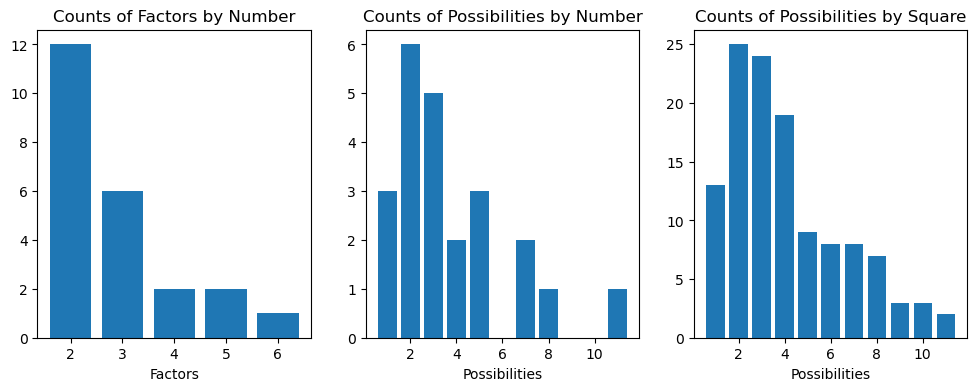

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
quickbar(axes[0], tg_factors_by_number, 'Factors', 'Counts of Factors by Number')
quickbar(axes[1], tg_possibilities_by_number, 'Possibilities', 'Counts of Possibilities by Number')
quickbar(axes[2], tg_possibilities_by_square, 'Possibilities', 'Counts of Possibilities by Square');

Fixed a bug in `Grid` where I had been testing for squares beyond the end of the puzzle, and because `Qs` is a `defaultdict` it added to the keys instead of raising an exception.

The above distributions seem useful, although I'm not yet sure what they would be compared with. And also I anticipate computing some statistic for each of a large number of grids, and then making some statements about those grids in aggregate.

Some other potential features, simple ones, include:

- the quantity or proportion of clues that are prime numbers
- the maximum possibilities for a number or square
- subtracting the single possibilities (forced moves) from the size of the puzzle

In [29]:
def is_prime(n):
    assert n == int(n) and n > 1
    if n == 2:
        return True
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return False
    return True

assert all(is_prime(n) for n in [2, 3, 5, 7, 11, 97])
assert not any(is_prime(n) for n in [4, 6, 8, 9, 10, 63, 99])

In [30]:
tg_primes = sum(count for n, count in tg_factors_by_number if is_prime(n))
print(f"{tg_primes} primes out of {len(test_grid.Ns)} = {tg_primes / len(test_grid.Ns):.0%}")

20 primes out of 23 = 87%


Gemini also suggested a few measures of the distribution of clues within the grid...

- clue density / mean rectangle area
- spatial dispersion / nearest neighbor
- area variance

...which I may look into soon. And I'm also interested in biases in number placement, like with a particular grid generator, are certain numbers more likely to appear in certain quadrants than in others. Or how does the presence of certain numbers in the center correlate with number of solutions.

I think my next step will be either to write some grid generator and start reviewing some of the above metrics, or scrape a site like <a href="https://puzz.link/db/?type=shikaku">puzz.link</a> or <a href="https://www.janko.at/Raetsel/Sikaku/index.htm">janko.at</a> and review statistics for the puzzles collected.

## 2026-01-06: First refactor

In [31]:
class Grid_v2:
    """Changing internal representation to {(r, c): n}.

    Standardizing with constructor classmethods.
    """
    def __init__(self, d, H, W):
        self.d = d
        self.H = H
        self.W = W
        self.MAX = 2 ** (self.H * self.W) - 1

        # Number for a given Square
        self.Ns = {2 ** (r * self.W + c): n for (r, c), n in self.d.items()}

        self.Rs = defaultdict(list)  # list of possible Rectangles containing a given Number
        self.Qs = defaultdict(list)  # list of possible Rectangles containing a given Square
        for this_p, n in self.Ns.items():
            r, c = divmod(int(log2(this_p)), self.W)  # convert bit back to row and column
            other_ps = sum(self.Ns) - this_p
            F = factors(n)
            for h, w in zip(F, reversed(F)):  # all possible Rectangle shapes
                for dh in range(h):           # all possible horizontal offsets
                    for dw in range(w):       # all possible vertical offsets
                        rectangle = self.bitmask_rectangle(r - dh, c - dw, h, w)
                        if rectangle and not rectangle & other_ps:  # has set bits and doesn't overlap any other Number
                            self.Rs[this_p].append(rectangle)
                            for r0 in range(r - dh, r - dh + h):
                                for c0 in range(c - dw, c - dw + w):
                                    self.Qs[2 ** (r0 * self.W + c0)].append(rectangle)

    def bitmask_rectangle(self, r, c, h, w):
        if r < 0 or c < 0 or r + h > self.H or c + w > self.W:
            return 0
        result = 0
        for r0 in range(r, r + h):
            for c0 in range(c, c + w):
                result += 2 ** (r0 * self.W + c0)
        return result

    def dfs(self, rs: set):
        current = sum(rs)  # union of accumulated rectangles
        if current == self.MAX:
            yield rs
        # continue from some empty square; for now, using lowest zero bit
        lowest_zero_bit = ~current & (current + 1)
        if lowest_zero_bit <= self.MAX:
            for rectangle in self.Qs[lowest_zero_bit]:
                if not rectangle & current:
                    next_rs = rs | {rectangle}
                    yield from self.dfs(next_rs)

    def solve(self):
        yield from self.dfs(set())

    def __repr__(self):
        output = []
        spacer_row = '+' + '--+' * self.W
        output.append(spacer_row)
        for r in range(self.H):
            row = []
            for c in range(self.W):
                row.append(f"{self.d.get((r, c), ''):>2}")
            output.append('|' + '|'.join(row) + '|')
            output.append(spacer_row)
        return '\n'.join(output)

    @classmethod
    def from_csv(cls, s):
        lines = s.strip().split('\n')
        H = len(lines)
        W = len(lines[0].split(','))
        d = {}
        for r, row in enumerate(lines):
            for c, char in enumerate(row.split(',')):
                if char:
                    d[(r, c)] = int(char)  # convert row and column to bit
        return cls(d, H, W)

    @classmethod
    def from_pzpr(cls, s):
        return cls(*parse_pzpr(s))

    @classmethod
    def from_janko(cls, s):
        return cls(*parse_janko(s))

In [32]:
tg2 = Grid_v2.from_csv(sample_grid_cleaned)

In [33]:
visualize_ascii(tg2, [x for x in tg2.solve()][0], 'test_grid')

2026-01-16 edit: I removed the Janko parser Gemini wrote because it didn't match the format.

## 2026-01-07: First random grid generator

I just want to start with an algorithm that will produce valid puzzles. Here's what I came up with:
```
Track the row index of the first open square in each column.
While any open squares are within the grid:
- Select the topmost of these open squares; if tied, the leftmost. This will be the upper-left corner of a rectangle.
- Find the maximum width by checking columns to the right until one is lower.
- Find the maximum height as distance to bottom.
- If max_width = max_height = 1, we've reached a dead end, and this grid fails.
- Randomly select a width <= max_width and height <= max_height such that 1 < area <= max_area.
- Append rectangle to results.
- Adjust tracked open squares.
```

For now I'm going to create a `Rectangle` class because I'm not sure in what order to put the row, column, height, and width. Gemini says (r, c, w, h) is somewhat of a standard for Shikaku, but r/c and w/h seem like they're in opposite orders. I'll reference fields by name rather than by index.

In [34]:
from collections import namedtuple

class Rectangle(namedtuple('Rectangle', ['r', 'c', 'w', 'h'])):
    @property
    def area(self):
        return self.h * self.w

    def bitmask(self, H, W):
        if self.r + self.h > H or self.c + self.w > W:
            return 0
        result = 0
        for r0 in range(self.r, self.r + self.h):
            for c0 in range(self.c, self.c + self.w):
                result += 2 ** (r0 * W + c0)
        return result

In [35]:
class Grid_Generator_v1:
    def __init__(self, H, W, max_area, seed=None):
        if seed is not None:
            random.seed(seed)
        self.H = H
        self.W = W
        self.max_area = max_area
        self.rectangles = []
        self.grid = None

    def run(self):
        if self.fill_rectangles():
            self.place_numbers()
            return self.grid

    def fill_rectangles(self):
        self.rectangles.clear()
        top_open = [0] * self.W
        while min(top_open) < self.H:
            c = top_open.index(min(top_open))
            r = top_open[c]
            i = c + 1
            while i < self.W and top_open[i] == r:
                i += 1
            max_width = i - c
            max_height = self.H - r
            if max_width == max_height == 1:
                self.rectangles.clear()
                return False
            w = h = 1
            while w == h == 1 or w * h > self.max_area:
                w = random.randint(1, max_width)
                h = random.randint(1, max_height)
            rectangle = Rectangle(r, c, w, h)
            self.rectangles.append(rectangle)
            for c0 in range(c, c + w):
                top_open[c0] += h
        return True

    def place_numbers(self):
        d = {}
        for rectangle in self.rectangles:
            dh = random.randrange(rectangle.h)
            dw = random.randrange(rectangle.w)
            d[(rectangle.r + dh, rectangle.c + dw)] = rectangle.area
        self.grid = Grid_v2(d, self.H, self.W)

Despite not wanting to tune rectangle size at first, I decided to add `max_area` when I saw how often the first rectangle dominated the grid.

In [36]:
g = Grid_Generator_v1(11, 11, 16, seed='switch').run()
if g is not None:
    print(g)
    [visualize_ascii(g, x) for x in g.solve()];

+--+--+--+--+--+--+--+--+--+--+--+
| 4|  | 4| 4|  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  | 3|  |  |  |  | 6|  | 3|
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |14|  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  | 9|  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 5|  |  |  |  |  |  |  |  |  | 7|
+--+--+--+--+--+--+--+--+--+--+--+
|  | 9|  |  |  |  | 8|  |  |16|  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 4|  |  |10| 4|  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  | 4|  |  | 2|  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  | 2|  |  |  | 3|  |  |
+--+--+--+--+--+--+--+--+--+--+--+


Dead ends are frequent.

In [37]:
def count_dead_ends(side, max_area, N):
    return sum(Grid_Generator_v1(side, side, max_area).run() is None
               for _ in range(N))

In [38]:
sides = [5, 8, 10, 12]
max_areas = [10, 12, 16]

random.seed('spectacles')
print(f"    {'  '.join(str(m) for m in max_areas)}")
for side in sides:
    print(f"{side:>2}", [count_dead_ends(side, max_area, 100)
                         for max_area in max_areas])

    10  12  16
 5 [47, 51, 41]
 8 [59, 66, 47]
10 [81, 73, 68]
12 [82, 82, 85]


In [39]:
random.seed('waistcoat')
count_dead_ends(20, 25, 1000)

935

It feels like the more space that needs to be filled, the more likely to run into a dead end. So I'd like to reduce the frequency of dead ends, or find a way to backtrack. (The rectangle directly above the $1 \times 1$ square could always have been one row taller. Rewind to that point?)

I also now have a generator that I can use to start compiling statistics. Before I start tweaking to reduce dead ends, I'd like to look at what other statistics seem off track:

- Where do different numbers tend to appear: top/bottom, left/right, center/edge/corner?
- How frequent are different numbers? How does this compare with publicly available puzzles?
- Clue density, spatial disperson, area variance (Gemini's suggestions a few days ago).

## 2026-01-11: Avoiding dead ends by extending

It dawned on me that if the algorithm reaches a dead end, not only will that always be in the bottom row, but also at least one of the following will be true:

- The rectangle directly left of the dead-end square will have height 1.
- The rectangle directly above the dead-end square will have width 1.

Therefore I can check for these two conditions, extend one of those rectangles to include the square, and continue with any remaining open squares.

Here's why at least one of the above statements must be true:

- For an open square to be a dead-end square, it must be in the bottom row. By this construction algorithm, all squares below any open square are also open. So any open square above the bottom row can be part of a rectangle of height at least 2 and therefore is not a dead end.
- For a rectangle directly above a dead-end square, its right-most column is the column of the dead-end square. In other words, this rectangle does not extend farther right than the dead-end square. If it did, by this construction the square to the right of the dead-end square would be open, as no other rectangle could reach it, meaning the dead-end square could be part of a rectangle with width at least 2 and therefore is not a dead end.
- Let's say the dead-end square is $(r,\;c)$.
  - If the rectangle directly left of the dead-end square has height greater than 1, it covers square $(r-1,\;c-1)$. Therefore the rectangle directly above the dead-end square does not cover $(r-1,\;c-1)$ and must have width 1.
  - If the rectangle directly above the dead-end square has width greater than 1, it covers square $(r-1,\;c-1)$. Therefore the rectangle directly above the dead-end square does not cover $(r-1,\;c-1)$ and must have height 1.
 
Adding a couple of methods to return a copy of the rectangle extended to cover the dead-end square.

In [40]:
class Rectangle(namedtuple('Rectangle', ['r', 'c', 'w', 'h'])):
    @property
    def area(self):
        return self.h * self.w

    def extend_down(self):
        cls = type(self)
        return cls(self.r, self.c, self.w, self.h + 1)

    def extend_right(self):
        cls = type(self)
        return cls(self.r, self.c, self.w + 1, self.h)

    def bitmask(self, H, W):
        if self.r + self.h > H or self.c + self.w > W:
            return 0
        result = 0
        for r0 in range(self.r, self.r + self.h):
            for c0 in range(self.c, self.c + self.w):
                result += 2 ** (r0 * W + c0)
        return result

Now adding logic to check the two cases.

In [41]:
class Grid_Generator_v1:
    def __init__(self, H, W, max_area, seed=None):
        if seed is not None:
            random.seed(seed)
        self.H = H
        self.W = W
        self.max_area = max_area
        self.rectangles = []
        self.grid = None

    def run(self):
        if self.fill_rectangles():
            self.place_numbers()
            return self.grid

    def fill_rectangles(self):
        self.rectangles.clear()
        top_open = [0] * self.W
        while min(top_open) < self.H:
            c = top_open.index(min(top_open))
            r = top_open[c]
            i = c + 1
            while i < self.W and top_open[i] == r:
                i += 1
            max_width = i - c
            max_height = self.H - r
            if max_width == max_height == 1:
                # Search for rectangle of width 1 directly above
                match_above = next(((i, rectangle) for i, rectangle in enumerate(self.rectangles)
                                    if rectangle.c == c and rectangle.r + rectangle.h == r), None)
                if match_above:
                    i, rectangle = match_above
                    self.rectangles[i] = rectangle.extend_down()
                    top_open[c] += 1
                    continue
                # Search for rectangle of height 1 directly left
                match_left = next(((i, rectangle) for i, rectangle in enumerate(self.rectangles)
                                   if rectangle.r == r and rectangle.c + rectangle.w == c), None)
                if match_left:
                    i, rectangle = match_left
                    self.rectangles[i] = rectangle.extend_right()
                    top_open[c] += 1
                    continue
                # should be unreachable
                return False
            w = h = 1
            while w == h == 1 or w * h > self.max_area:
                w = random.randint(1, max_width)
                h = random.randint(1, max_height)
            rectangle = Rectangle(r, c, w, h)
            self.rectangles.append(rectangle)
            for c0 in range(c, c + w):
                top_open[c0] += h
        return True

    def place_numbers(self):
        d = {}
        for rectangle in self.rectangles:
            dh = random.randrange(rectangle.h)
            dw = random.randrange(rectangle.w)
            d[(rectangle.r + dh, rectangle.c + dw)] = rectangle.area
        self.grid = Grid_v2(d, self.H, self.W)

Did it work?

In [42]:
random.seed('chamomile')
count_dead_ends(10, 12, 100)

0

In [43]:
g = Grid_Generator_v1(10, 20, 16, seed='wintergreen').run()
if g is not None:
    print(g)
    [visualize_ascii(g, x) for x in g.solve()];

+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |16|  |  |  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  | 4|  |  |  |14|  |  |  |15|  |  |  |  |  |  | 5|
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  | 4|  |  |  |  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  |12|  |  | 2|  |  |  |  |  | 6|  |  |  |  |  |  |12|  |  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  | 3|  |  |  |  |  |  |  | 5|  |  |  |  |  | 6| 2|  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  | 9|  |  |  |  |  |  |  | 3|  |  |  |  |  |  |  |  |  | 5|
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  | 8|  |  |  |  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  | 2|  |  |  |  |  | 3|  |  |  |  |12|  |  |  | 2|  |
+--+--+-

The above parameters fail with the initial version but succeed with the fixed version. Without debugging I'm not sure where it previously failed, but using the labels in the second solution, the dead-end square could have been in any of `k`, `9`, `Z`, `u`, or `X`. Given the number of opportunities to fail, the previous failure rate is not surprising.

Now that I can generate large grids, I've run into an issue with my `visualize_ascii` function — it only supports up to 62 rectangles.

## 2026-01-13: First statistics

I'll clean this up after exploring.

In [44]:
class Samples:
    def __init__(self, side, max_area, N, seed=None):
        if seed is not None:
            random.seed(seed)
        self.side = side
        self.max_area = max_area
        self.N = N
        self.grids = [Grid_Generator_v1(side, side, max_area).run()
                      for _ in range(N)]
        assert all(g is not None for g in self.grids)
        self.solutions = [list(g.solve()) for g in self.grids]
        assert all(L for L in self.solutions)
        self.frequencies = defaultdict(Counter)
        for g in self.grids:
            for n, q in Counter(g.d.values()).items():
                self.frequencies[n][q] += 1

In [45]:
samples1 = Samples(10, 20, 1000, 'wabbit')

In [46]:
points1 = defaultdict(Counter)
counts1 = Counter()
for g in samples1.grids:
    for p, n in g.d.items():
        points1[n][p] += 1
        counts1[n] += 1

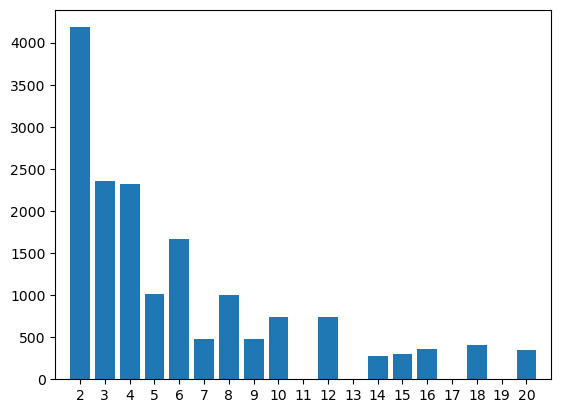

In [47]:
plt.bar(*zip(*counts1.items()))
plt.xlim(1, samples1.max_area + 1)
plt.xticks(range(2, samples1.max_area + 1));

Okay, checking the distribution of position of each number. I had really been trying to stick to the standard library, but NumPy is so convenient here.

In [48]:
import numpy as np

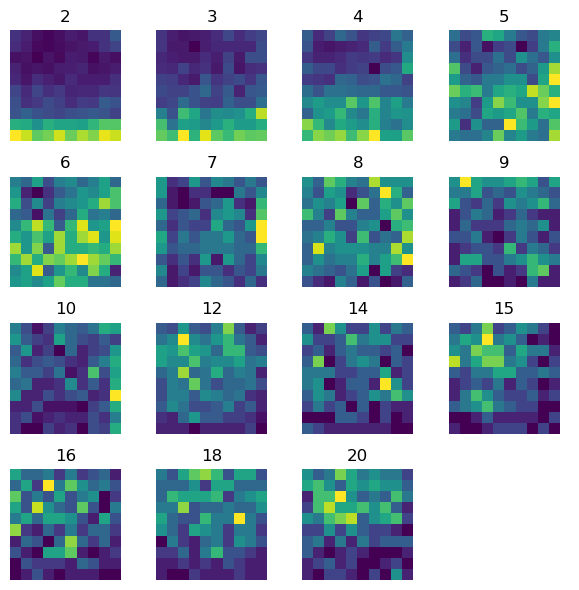

In [49]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, (n, ps) in enumerate(sorted(points1.items())):
    arr = np.zeros((samples1.side, samples1.side), dtype=int)
    for (r, c), v in ps.items():
        arr[r, c] = v
    ax = axes.flat[i]
    ax.imshow(arr)
    ax.set_axis_off()
    ax.set_title(n)
for j in range(i+1, 4*4):
    axes.flat[j].axis('off')
plt.tight_layout();

A few observations:

- This is pretty much what I expected. I like that the asymmetry appears to be not just up-down but left-right as well.
- For the largest numbers, I would expect a slight bias against the very edge, because if a rectangle of area e.g. 18 is along an edge, its other dimension is at least 2, and a square on the edge would be no more likely to be selected then a square one line away from the edge. (I'm randomly placing the number within each rectangle.) That square one line away is also part of rectangles the square on the edge is not. If the square on the edge occurs more frequently than the square one line away, this would be due to randomness and small sample size.
- What would be unbiased is if I were looking at rectangles rather than numbers. Which I'm probably not going to get into, because while rectangles are an intermediate step for the grids I created, they're not readily available for puzzles I may download. And if those puzzles only have a single solution, they're not necessarily going to help me analyze everything I'd like to for the puzzles I generate.

What do these heatmaps look like if they all use the same heat scale?

In [50]:
from itertools import chain

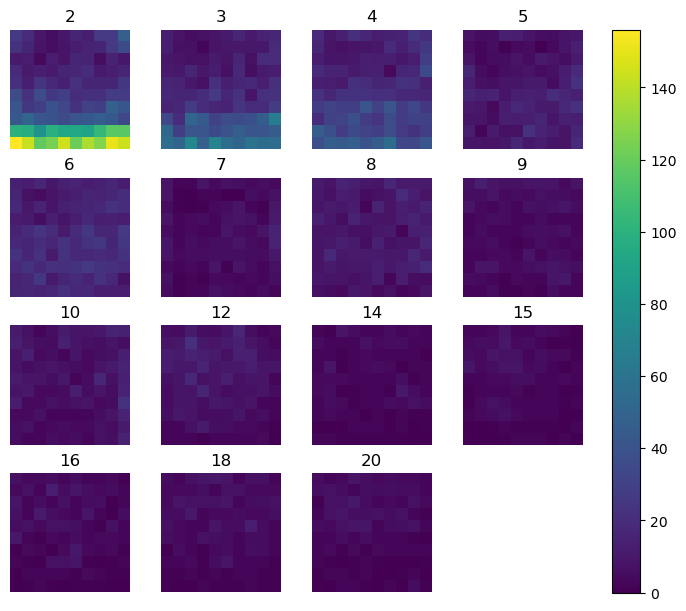

In [51]:
v_max = max(chain.from_iterable(ps.values() for ps in points1.values()))

fig, axes = plt.subplots(4, 4, figsize=(7, 6), layout='constrained')
for i, (n, ps) in enumerate(sorted(points1.items())):
    arr = np.zeros((samples1.side, samples1.side), dtype=int)
    for (r, c), v in ps.items():
        arr[r, c] = v
    ax = axes.flat[i]
    im = ax.imshow(arr, vmin=0, vmax=v_max)
    ax.set_axis_off()
    ax.set_title(n)
for j in range(i+1, 4*4):
    axes.flat[j].axis('off')
fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.05, pad=0.05);

Okay, well, that's probably a good picture to reinforce that 2 is more common than just every other number just about everywhere.

Let's get started with real statistics. What is the average location of each number?

In [52]:
means1 = {}
total_r_numerator = 0
total_c_numerator = 0
total_denominator = 0
for n, ps in points1.items():
    r_numerator = 0
    c_numerator = 0
    denominator = 0
    for (r, c), v in ps.items():
        r_numerator += r * v
        c_numerator += c * v
        denominator += v
    total_r_numerator += r_numerator
    total_c_numerator += c_numerator
    total_denominator += denominator
    means1[n] = (r_numerator / denominator, c_numerator / denominator)
overall_mean1 = (total_r_numerator / total_denominator, total_c_numerator / total_denominator)

How far is each number's mean from the center of the grid?

In [53]:
center_r = center_c = (samples1.side - 1) / 2
for n, (r, c) in sorted(means1.items()):
    print(f"{n:>2} ( {r - center_r: .2f}, {c - center_c: .2f} )")

 2 (  2.21,  0.11 )
 3 (  1.72,  0.22 )
 4 (  1.07,  0.08 )
 5 (  0.52,  0.48 )
 6 (  0.29,  0.15 )
 7 ( -0.06,  0.48 )
 8 ( -0.28,  0.17 )
 9 ( -0.56,  0.09 )
10 ( -0.44,  0.47 )
12 ( -0.80, -0.42 )
14 ( -0.74, -0.16 )
15 ( -0.94, -0.75 )
16 ( -0.90, -0.49 )
18 ( -1.10,  0.02 )
20 ( -1.27, -0.33 )


On the whole this is what I expected.

How does the mean for each number compare with the means for all clues? (This is weighted by the frequency of each number.)

In [54]:
overall_r, overall_c = overall_mean1
for n, (r, c) in sorted(means1.items()):
    print(f"{n:>2} ( {r - overall_r: .2f}, {c - overall_c: .2f} )")

 2 (  1.39,  0.00 )
 3 (  0.90,  0.11 )
 4 (  0.25, -0.03 )
 5 ( -0.30,  0.37 )
 6 ( -0.52,  0.03 )
 7 ( -0.88,  0.37 )
 8 ( -1.10,  0.06 )
 9 ( -1.38, -0.02 )
10 ( -1.25,  0.36 )
12 ( -1.62, -0.53 )
14 ( -1.56, -0.27 )
15 ( -1.75, -0.86 )
16 ( -1.71, -0.60 )
18 ( -1.92, -0.09 )
20 ( -2.08, -0.44 )


How about the average <a href="https://en.wikipedia.org/wiki/Taxicab_geometry">taxicab</a> and <a href="https://en.wikipedia.org/wiki/Euclidean_distance">Euclidean</a> distance from the center for each number?

In [55]:
taxicab1 = {}
euclidean1 = {}
total_t_numerator = 0
total_e_numerator = 0
total_denominator = 0
for n, ps in points1.items():
    t_numerator = 0
    e_numerator = 0
    denominator = 0
    for (r, c), v in ps.items():
        t_numerator += v * (abs(r - center_r) + abs(c - center_c))
        e_numerator += v * ((r - center_r) ** 2 + (c - center_c) ** 2)
        denominator += v
    total_t_numerator += t_numerator
    total_e_numerator += e_numerator
    total_denominator += denominator
    taxicab1[n] = t_numerator / denominator
    euclidean1[n] = (e_numerator / denominator) ** 0.5
overall_taxicab1 = total_t_numerator / total_denominator
overall_euclidean1 = (total_e_numerator ** 0.5) / total_denominator

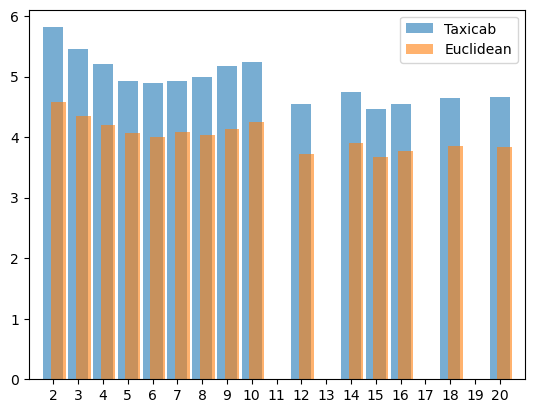

In [56]:
plt.bar(*zip(*taxicab1.items()), width=0.8, label='Taxicab', alpha=0.6)
er, ec = zip(*euclidean1.items())
plt.bar([r + 0.2 for r in er], ec, width=0.6, label='Euclidean', alpha=0.6)
plt.xlim(1, samples1.max_area + 1)
plt.xticks(range(2, samples1.max_area + 1))
plt.legend();

Hmm. I wonder whether all greater-than-side-length numbers having a lower average distance than all smaller numbers has to do with not being able to form a $1 \times w$ or $h \times 1$ rectangle. And whether the distance is correlated with the "squareness" of the rectangle. So I may need to analyze rectangles rather than just numbers after all.

A couple more things for tonight. How many solutions does each grid have?

In [57]:
num_solutions1 = Counter(len(L) for L in samples1.solutions)

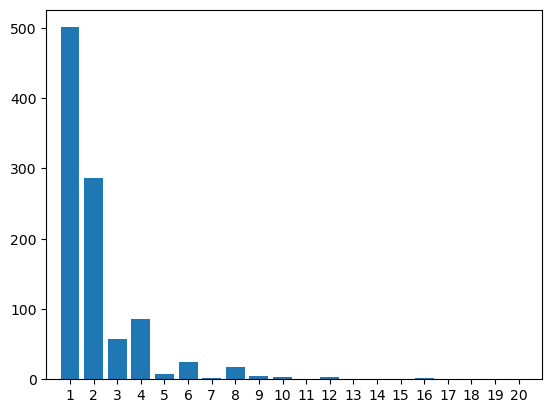

In [58]:
plt.bar(*zip(*num_solutions1.items()))
plt.xlim(0, max(num_solutions1) + 1)
plt.xticks(range(1, max(num_solutions1) + 1));

And in how many grids did each number appear a certain ...number of times? (If only I had referred to them as clues from the start.)

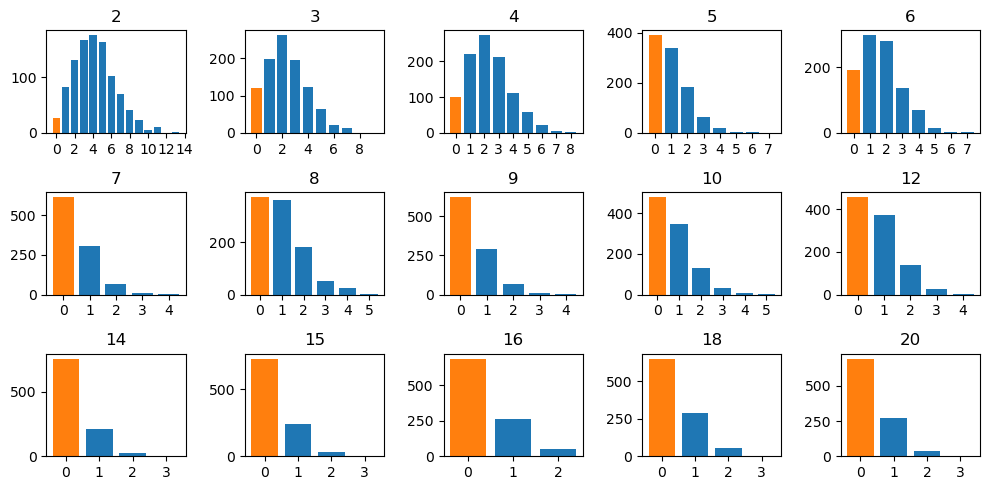

In [59]:
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(3, 5, figsize=(10, 5))
for i, (n, qs) in enumerate(sorted(samples1.frequencies.items())):
    zero = samples1.N - sum(qs.values())
    ax = axes.flat[i]
    ax.bar(*zip(*qs.items()))
    ax.bar([0], [zero])
    ax.set_title(n)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout();

## 2026-01-16: Download some puzzles

Slightly adapted from Gemini so I can feed it into the constructor.

In [60]:
import urllib.request
import re
from time import sleep

def get_janko_shikaku(puzzle_num):
    url = f"https://www.janko.at/Raetsel/Sikaku/{puzzle_num:03d}.a.htm"
    with urllib.request.urlopen(url) as response:
        html = response.read().decode('utf-8')
        # print(html)
    script_content = re.search(r'<script id="data" type="application/x-janko">(.*?)</script>', html, re.DOTALL)
    if script_content:
        data = script_content.group(1)
        problem_match = re.search(r'\[problem\]\n(.*)\n\[solution\]', data, re.DOTALL)
        if problem_match:
            return problem_match.group(1)
    return None

def get_all_janko():
    for puzzle_num in range(1, 521):
        text = get_janko_shikaku(puzzle_num)
        with open(f'janko/{puzzle_num:>03}.txt', 'w') as f:
            print(text, file=f)
            print('.', end='')
        sleep(1)
    print()

In [61]:
# get_all_janko()

Rewriting this because Gemini's version from a while ago expected a different format than what actually appears in the HTML.

In [62]:
def parse_janko(file):
    with open(file) as f:
        lines = f.read().strip().split('\n')
    d = {}
    for r, line in enumerate(lines):
        for c, n in enumerate(line.split()):
            if n == '-':
                continue
            d[(r, c)] = int(n)
    H = r + 1
    W = c + 1
    return d, H, W

`Grid_v2.from_janko()` forwards a string to `parse_janko()` which interpretes the string as a filename. Perhaps should clean that up...

In [63]:
test_janko_grid = Grid_v2.from_janko('janko/001.txt')
print(test_janko_grid)
random.seed('diagonal')
[visualize_ascii(test_janko_grid, x) for x in test_janko_grid.solve()];

+--+--+--+--+--+--+--+--+--+--+
|  | 4|  |  |  | 2|  |  |  | 3|
+--+--+--+--+--+--+--+--+--+--+
| 3|  |  |  | 5|  |  |  | 3|  |
+--+--+--+--+--+--+--+--+--+--+
|  |  |  | 3|  |  |  | 6|  |  |
+--+--+--+--+--+--+--+--+--+--+
|  |  | 3|  |  |  | 5|  |  |  |
+--+--+--+--+--+--+--+--+--+--+
|  | 3|  |  |  | 4|  |  |  | 5|
+--+--+--+--+--+--+--+--+--+--+
| 2|  |  |  | 7|  |  |  | 3|  |
+--+--+--+--+--+--+--+--+--+--+
|  |  |  | 5|  |  |  | 4|  |  |
+--+--+--+--+--+--+--+--+--+--+
|  |  | 5|  |  |  | 4|  |  |  |
+--+--+--+--+--+--+--+--+--+--+
|  | 6|  |  |  | 2|  |  |  | 3|
+--+--+--+--+--+--+--+--+--+--+
| 2|  |  |  | 5|  |  |  | 3|  |
+--+--+--+--+--+--+--+--+--+--+


What size grids do we have here?

In [64]:
jankos = [parse_janko(f"janko/{num:>03}.txt") for num in range(1, 521)]
janko_sizes = Counter((H, W) for _, H, W in jankos)

In [65]:
janko_sizes.most_common(10)

[((10, 10), 138),
 ((17, 17), 91),
 ((14, 24), 74),
 ((10, 18), 33),
 ((12, 16), 24),
 ((12, 14), 21),
 ((15, 15), 21),
 ((13, 13), 16),
 ((14, 18), 13),
 ((12, 12), 11)]

In [66]:
jankos10x10 = {num: Grid_v2(d, H, W) for num, (d, H, W) in enumerate(jankos, start=1)
               if H == 10 and W == 10}

In [67]:
len(jankos10x10)

138

It turns out that three of the Janko puzzles have multiple solutions.

In [68]:
# for num, (d, H, W) in enumerate(jankos, start=1):
#     g = Grid_v2(d, H, W)
#     solution_count = sum(1 for _ in g.solve())
#     if solution_count > 1:
#         print(f"{num:>3} {solution_count}")

```
127 2
128 3
520 2
```
Puzzle 128 has over 70 clues, which breaks `visualize_ascii()`, so here are the other two.

In [69]:
for num in [127, 520]:
    print(num)
    g = Grid_v2(*jankos[num-1])
    print(g)
    [visualize_ascii(g, x) for x in g.solve()]
    print()

127
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  | 4|  |  |  | 9|  |  |  |  |  |  |  |  |  | 9|  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
| 3|  |  |  |  |  |  | 6|  |  | 2|  |  |12|  |  |  |  | 9|  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  | 5|  |  |  |  |  |  |  |  | 6|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  | 8|  |  |  |10|  |  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  | 5|  |  | 2|  |  |  |  |  |  |  |  |  |  |  |  |  |10|
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |12|  |  |  |  |  |  |  |  |  |  |  |  |12| 6|  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
| 4|  |10|  |  |  | 2|  |  |  |10|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+--+--+--+-


520
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  | 6|  |  |  | 6|  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  | 6|  |  |  |  |  |  |  | 4|  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 7|  |  |  | 4| 4| 4|  |  |  | 9|
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  | 4|  |  |  | 4|  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  | 9|  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  | 4|  |  |  | 4|  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
| 3|  |  |  | 4| 4| 4|  |  |  | 8|
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  |  |  |  |  |  |  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
|  | 8|  |  |  |  |  |  |  | 4|  |
+--+--+--+--+--+--+--+--+--+--+--+
|  |  |  | 5|  |  |  | 6|  |  |  |
+--+--+--+--+--+--+--+--+--+--+--+
